**Содержание**<a id='toc0_'></a>    
- [ Прогнозирование заказов такси](#toc1_)    
  - [Подготовка данных](#toc1_1_)    
  - [Анализ](#toc1_2_)    
  - [Обучение](#toc1_3_)    
      - [Создание признаков](#toc1_3_1_1_)    
      - [Разбивка на выборки](#toc1_3_1_2_)    
      - [LinearRegresson](#toc1_3_1_3_)    
      - [Случайный лес](#toc1_3_1_4_)    
      - [LightGBM](#toc1_3_1_5_)    
      - [CatBoost](#toc1_3_1_6_)    
      - [Выбор лучшей на основе валидации](#toc1_3_1_7_)    
  - [Тестирование](#toc1_4_)    
    - [Вывод](#toc1_4_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[ Прогнозирование заказов такси](#toc0_)

**Описание:**

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

**Условие:**

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Количество заказов находится в столбце `num_orders`.


## <a id='toc1_1_'></a>[Подготовка данных](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
display(HTML("<style>.container { width:75% !important; }</style>")) # больше не делаю, экран не такой большой как хотелось бы

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Рассматриваемый период с 1го марта 18го года по 31 августа 18го года. 

Целевой признак - количество запасов. 
В качестве индекса - даты через каждые 10 минут. 

In [4]:
# проверяем хролонолию
if data.index.is_monotonic == True:
    print('Хронологический порядок индексов')
else:
    print('Не хронологический порядок')

Хронологический порядок индексов


In [5]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Сделали ресемплирование в 1 час, с суммированием всех значений в этом диапозоне.

## <a id='toc1_2_'></a>[Анализ](#toc0_)

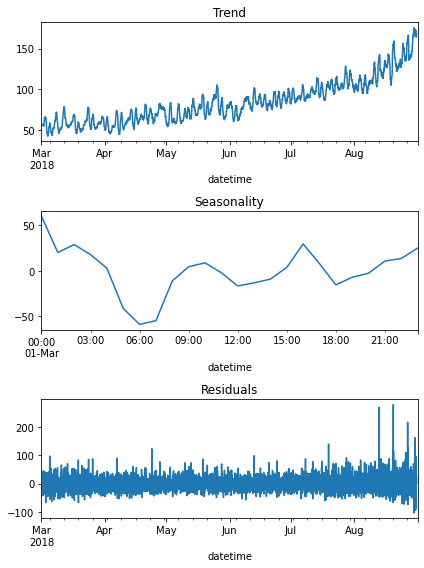

In [6]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['1 March 2018'].plot(ax=plt.gca())  # < напишите код здесь >
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Residuals')
plt.tight_layout()

- В трендах наблюдается увлечение заказов.
- В сезонности за 1 день видно, что самое не актуальное время 6-7 утра, а пик достигается к полуночи.

## <a id='toc1_3_'></a>[Обучение](#toc0_)

#### <a id='toc1_3_1_1_'></a>[Создание признаков](#toc0_)

In [7]:
# Создаем признаки
def make_features(data, max_lag, rolling_mean_size):
#     data['month'] = data.index.month
#     data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # < напишите код здесь >
    data['rolling_mean'] = data['num_orders'].shift().rolling(window=rolling_mean_size).mean()
    return data

In [8]:
make_features(data,4,10)
data = data.dropna()
data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,
2018-03-01 10:00:00,64,3,10,69.0,34.0,15.0,12.0,52.5
2018-03-01 11:00:00,96,3,11,64.0,69.0,34.0,15.0,46.5
2018-03-01 12:00:00,30,3,12,96.0,64.0,69.0,34.0,47.6
2018-03-01 13:00:00,32,3,13,30.0,96.0,64.0,69.0,43.5
2018-03-01 14:00:00,48,3,14,32.0,30.0,96.0,64.0,40.1


#### <a id='toc1_3_1_2_'></a>[Разбивка на выборки](#toc0_)

In [9]:
train_v, test = train_test_split(data, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_v, shuffle=False, test_size=0.1)
print(train.index.min(), train.index.max())
print(valid.index.min(), valid.index.max())
print(test.index.min(), test.index.max())

2018-03-01 10:00:00 2018-07-28 01:00:00
2018-07-28 02:00:00 2018-08-13 14:00:00
2018-08-13 15:00:00 2018-08-31 23:00:00


In [10]:
f_train = train.drop(['num_orders'], axis=1)
t_train = train['num_orders']
f_val = valid.drop(['num_orders'], axis=1)
t_val = valid['num_orders']
f_test = test.drop(['num_orders'], axis=1)
t_test = test['num_orders']
display(f_train.shape)
display(f_val.shape)
display(f_test.shape)

(3568, 7)

(397, 7)

(441, 7)

#### <a id='toc1_3_1_3_'></a>[LinearRegresson](#toc0_)

In [11]:
model = LinearRegression()
model.fit(f_train,t_train )

pred_val = model.predict(f_val)
linear_rmse = np.sqrt(mean_squared_error(t_val, pred_val))

print("RMSE валидационной выборки:", linear_rmse) 

RMSE валидационной выборки: 42.411708527068846


#### <a id='toc1_3_1_4_'></a>[Случайный лес](#toc0_)

In [12]:
best_model = None
best_result = float('inf')
best_param = None
best_depth = None

for est in range(1,11):
    for depth in range(1,11):
        
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(f_train, t_train)
        pred_val = model.predict(f_val)
        rmse = np.sqrt(mean_squared_error(t_val, pred_val))
    
        if rmse < best_result:
            best_model = model
            best_param = est
            best_depth = depth
            best_result = rmse

print('Лучшая модель:', best_model)
print('Лучший параметр est', best_param)
print('Лучший параметр depth', best_depth)
print('RMSE', best_result)


Лучшая модель: RandomForestRegressor(max_depth=10, n_estimators=9, random_state=12345)
Лучший параметр est 9
Лучший параметр depth 10
RMSE 32.400482968787216


#### <a id='toc1_3_1_5_'></a>[LightGBM](#toc0_)

In [13]:
model = LGBMRegressor(random_state=12345, n_estimators=1000)

model.fit(f_train, t_train)

pred_val = model.predict(f_val)
mse = mean_squared_error(t_val, pred_val)
rmse_lgbm = np.sqrt(mse)
print('RMSE модели на валидационной выборке:', rmse_lgbm)

RMSE модели на валидационной выборке: 31.863312298493444


#### <a id='toc1_3_1_6_'></a>[CatBoost](#toc0_)

In [14]:
model =CatBoostRegressor(iterations=1000)

model.fit(f_train, t_train, verbose=200)
pred_val = model.predict(f_val)
mse = mean_squared_error(t_val, pred_val)
rmse_cat = np.sqrt(mse)

print('RMSE модели на валидационной выборке:', rmse_cat)

Learning rate set to 0.050057
0:	learn: 35.2231554	total: 48.5ms	remaining: 48.4s
200:	learn: 19.9760680	total: 330ms	remaining: 1.31s
400:	learn: 17.9193359	total: 609ms	remaining: 910ms
600:	learn: 16.3383141	total: 914ms	remaining: 607ms
800:	learn: 15.1864943	total: 1.22s	remaining: 304ms
999:	learn: 14.2246014	total: 1.52s	remaining: 0us
RMSE модели на валидационной выборке: 32.06915752512844


#### <a id='toc1_3_1_7_'></a>[Выбор лучшей на основе валидации](#toc0_)

In [15]:
table = {'Модели':
    ['Случайный лес', 'Линейная регрессия', 'LGBM', 'CatBoost'],
         'RMSE valid':[best_result, linear_rmse, rmse_lgbm, rmse_cat]
         
}

table = pd.DataFrame(table)
table.head()

,Модели,RMSE valid
0,Случайный лес,32.400483
1,Линейная регрессия,42.411709
2,LGBM,31.863312
3,CatBoost,32.069158


Лучшая метрика оказалась у модели CatBoost, с небольшим отставанием LGBM. 

## <a id='toc1_4_'></a>[Тестирование](#toc0_)

In [16]:
full_features = train_v.drop(['num_orders'], axis=1)
full_target = train_v['num_orders']


In [17]:
model =CatBoostRegressor(iterations=1000)

model.fit(full_features, full_target, verbose=100)
pred_test = model.predict(f_test)
mse = mean_squared_error(t_test, pred_test)
rmse_cat = np.sqrt(mse)

print('RMSE модели на тестовой выборке:', rmse_cat)

Learning rate set to 0.050898
0:	learn: 37.7756641	total: 2.35ms	remaining: 2.35s
100:	learn: 23.2681011	total: 153ms	remaining: 1.36s
200:	learn: 21.3427496	total: 303ms	remaining: 1.21s
300:	learn: 19.7765741	total: 465ms	remaining: 1.08s
400:	learn: 18.7296707	total: 608ms	remaining: 909ms
500:	learn: 17.9186954	total: 752ms	remaining: 749ms
600:	learn: 17.2283671	total: 899ms	remaining: 597ms
700:	learn: 16.5850151	total: 1.05s	remaining: 446ms
800:	learn: 15.9952418	total: 1.24s	remaining: 307ms
900:	learn: 15.4213197	total: 1.41s	remaining: 155ms
999:	learn: 14.9240477	total: 1.56s	remaining: 0us
RMSE модели на тестовой выборке: 45.05808922403923


Метрика достигнута! В условии задачи требование rmse не более 48, модель catboost показала 44,9. Мы не ошиблись в выборе модели. 

### <a id='toc1_4_1_'></a>[Вывод](#toc0_)

- Подготовили и изучили данные:

        - Целевой признак - количество запасов.
        - Индекс - даты, диапозон каждые 10 минут. 
        - Рассматриваемый период с 1 марта по 31 августа 18го года.
        - Индексы идут в хронологическом порядке.
        - Сделали ресемплирование в 1 час, с суммированием всех значений в этом диапозоне.

- Произвели анализ:

        - В трендах наблюдается увлечение заказов.
        - В сезонности за 1 день видно, что самое не актуальное время 6-7 утра, а пик достигается к полуночи.
        
- Поготовка и обучение моделей:

        - Создали признаки
        - Произвели разбивку на выборки
        - Построили 4 разных модели и обучили на тренировочных данных
        - В качестве промежуточных результатов была использована валидационная выборка
        - Собрали метрики по моделям в таблицу для сравнения результатов. 
        - Лучшая модель на валидационной выборке - CatBoost
        
- Тестирование:

        - Произвели предсказния лучшей модели (CatBoost) на тестовой выборке - RMSE - 45.05